In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('ggplot')
from matplotlib.colors import ListedColormap
import seaborn as sns

import re
import os
import pickle
from glob import glob
from preprocess_drone import preprocess, create_time_series_features
from drone_troopers.models.flight_classifier import read_files, scale_n_process

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
def get_file_paths(directory, extensions=['.csv', '.CSV', '.xlsx']):
    file_paths = []
    # Iterate over each extension
    for ext in extensions:
        # Use glob to find all files with the given extension in the directory and subdirectories
        file_paths.extend(glob(os.path.join(directory, '**', f'*{ext}'), recursive=True))
    return file_paths

In [5]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '1')

# Get the list of file paths
file_paths_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_normal)} normal log files.')

Found 116 normal log files.


In [6]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '-1')

# Get the list of file paths
file_paths_non_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_non_normal)} non-normal log files.')

Found 97 non-normal log files.


In [7]:
with open(os.path.join('FinalModel', 'drone_troopers', 'models', 'voting_classifier_model.pkl'), 'rb') as file:
    voting_clf = pickle.load(file)

In [8]:
path1 = r'C:\Python Programs\Tech-Troopers\Dhruv\Drone\logs\selected\-1\50 throttle not enough power(annotated).xlsx'
path2 = r'C:\Python Programs\Tech-Troopers\Dhruv\Drone\logs\selected\1\1\LOG00000\LOG.csv'

In [16]:
time_series_data = read_files([path1])
final_df = scale_n_process(time_series_data)
X = final_df.drop('flightId', axis=1)

In [17]:
y_pred_voting = voting_clf.predict(X)

In [52]:
# Individual classifier predictions
predictions = {}
for name, clf in voting_clf.named_estimators_.items():
    predictions[name] = clf.predict(X)
    
predictions['voting_clf'] = y_pred_voting

In [53]:
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.replace({1: 'Non Normal Operation', 0: 'Normal Operation'})
# Melt the DataFrame to long format
predictions_melted = predictions_df.melt(var_name='Classifier', value_name='Prediction')
predictions_melted

,Classifier,Prediction
0,logistic,Non Normal Operation
1,logistic,Non Normal Operation
2,logistic,Non Normal Operation
3,logistic,Non Normal Operation
4,logistic,Non Normal Operation
...,...,...
62791,voting_clf,Non Normal Operation
62792,voting_clf,Non Normal Operation
62793,voting_clf,Non Normal Operation
62794,voting_clf,Non Normal Operation


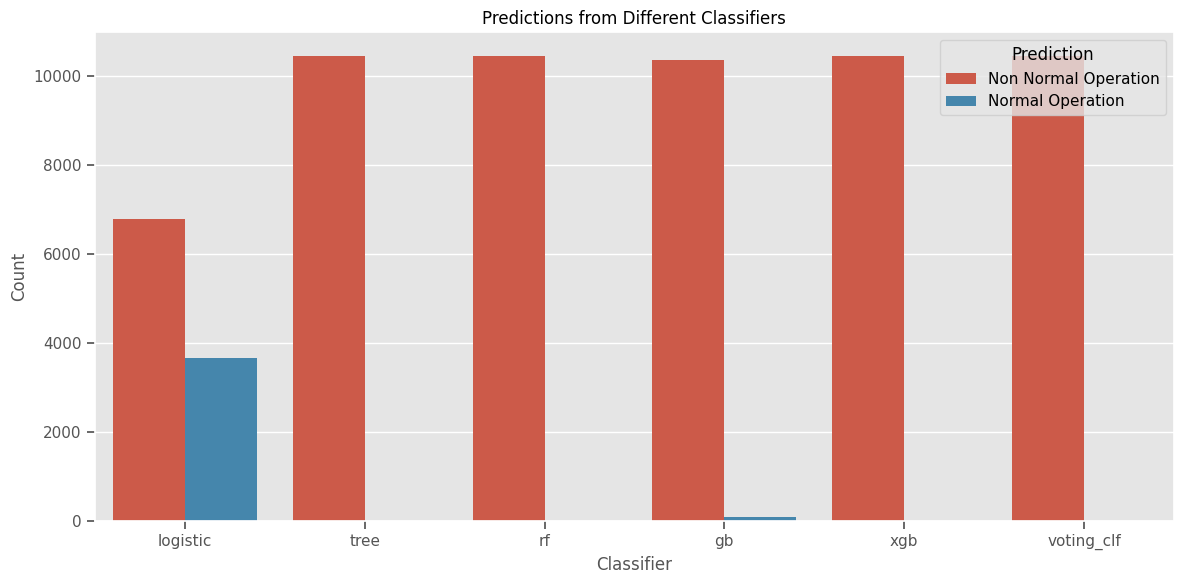

In [54]:
# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(data=predictions_melted, x='Classifier', hue='Prediction')
plt.title('Predictions from Different Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Prediction')
plt.tight_layout()
plt.show()

In [58]:
confidence = {}
for name, clf in voting_clf.named_estimators_.items():
    confidence[name] = clf.predict_proba(X)

# Calculate predicted probabilities for the voting classifier
# confidence['voting_clf'] = voting_clf.predict_proba(X)

In [72]:
overall_probs = {}

# Calculate overall probabilities for each classifier
for name, probs in confidence.items():
    # Calculate the mean probability across all samples for each class
    mean_probs = np.mean(probs, axis=0)
    overall_probs[name] = mean_probs

# Convert overall probabilities to a DataFrame for better readability
overall_probs_df = pd.DataFrame(overall_probs, index=['Normal Operation', 'Non Normal Operation'])

# Print the overall probabilities for each classifier
print("Overall Prediction Probabilities for Each Classifier:")
overall_probs_df

Overall Prediction Probabilities for Each Classifier:


,logistic,tree,rf,gb,xgb
Normal Operation,0.353389,0.0,0.000977,0.052877,0.00022
Non Normal Operation,0.646611,1.0,0.999023,0.947123,0.99978


In [75]:
print(overall_probs_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & logistic & tree & rf & gb & xgb \\
\midrule
Normal Operation & 0.353389 & 0.000000 & 0.000977 & 0.052877 & 0.000220 \\
Non Normal Operation & 0.646611 & 1.000000 & 0.999023 & 0.947123 & 0.999780 \\
\bottomrule
\end{tabular}



Text(0, 0.5, 'Probability')

<Figure size 600x300 with 0 Axes>

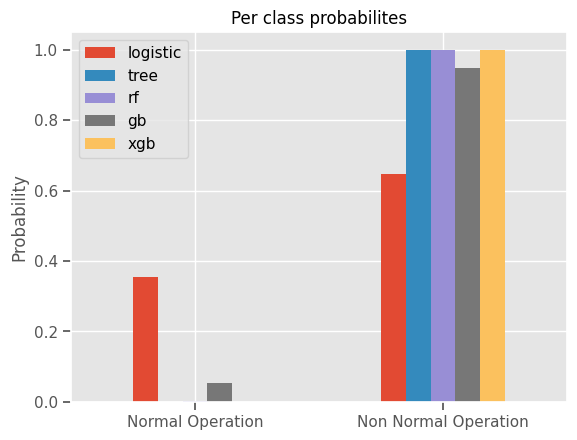

In [80]:
plt.figure(figsize=(6, 3))
overall_probs_df.plot(kind='bar')
plt.xticks([0, 1], ['Normal Operation', 'Non Normal Operation'], rotation=0);
plt.title('Per class probabilites');
plt.ylabel('Probability')

In [81]:
os.path.basename(path1)

'50 throttle not enough power(annotated).xlsx'